In [53]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import pyphen
import nltk
import spacy
import os
import re
import numpy as np
import pandas as pd
import logging
import math
import altair as alt
import heapq
import text_analysis as ta
from textblob import TextBlob as tb
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from scipy.stats.mstats import winsorize
from lexical_diversity import lex_div as ld

def j_and_j():
    return {
        'config': {
            'view': {
                'height': 300,
                'width': 800,
            },
            'mark': {
                'color': 'rgb(25,25,112)'
            },
            'axisLeft': {
                'labelFontSize': 12,
            },
            "title": {
                "fontSize": 24,
                "anchor": "start", # equivalent of left-aligned.
                "fontColor": 'rgb(46,46,46)',
                "fontWeight": 600,
                "offset": 10
            },
            "axisX": {
                "domain": True,
                "grid": False,
                "labelFontSize": 12,
                "titleFontSize": 12
            },
            "axisY": {
                "domain": False,
                "offset": 20,
                "grid": True,
                "fontSize": 16,
                "labelFontSize": 18,
                "labelAngle": 0, 
                "ticks": False,
                "titleFontSize": 14,
                "titleAngle": 0,
                "titleY": -10,
                "titleX": 18
            },
        }
    }

def convert_s_to_m(list_of_s=[]):
    minutes = [int(math.modf(second_ts / 60.0)[1]) for second_ts in list_of_s]
    minutes = ['0' + str(minute) if minute < 10 else str(minute) for minute in minutes]

    seconds = [math.modf(second_ts / 60.0)[0] for second_ts in list_of_s]
    seconds = [round(second * 60.0) for second in seconds]
    seconds = ['0' + str(second) if second < 10 else str(second) for second in seconds]

    return [minute + ':' + second for minute, second in zip(minutes, seconds)]

def read_words(directory = ''):
    files = os.listdir(directory)
    names = [os.path.splitext(file)[0] for file in files]
    words = {name: [] for name in names}

    for file, name in zip(files, names):
        with open(directory + '/' + file) as input:
            for line in input:
                if line:
                    if '\n' in line:
                        words[name].append(line[:-1].lower())
                    else:
                        words[name].append(line.lower())
    return words
# nltk.download('punkt')
# logging.basicConfig(level = logging.DEBUG)

alt.themes.register('j&j', j_and_j)
alt.renderers.enable('notebook')
alt.themes.enable('j&j')

[nltk_data] Downloading package punkt to /Users/julian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ThemeRegistry.enable('j&j')

## Trump Inauguration 2016 (What a day!)

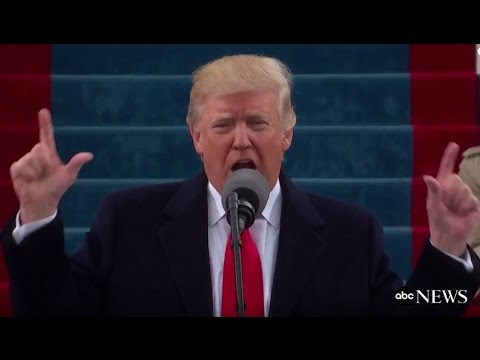

In [13]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('sRBsJNdK1t0')

In [2]:
trump = ta.TextAnalyser('/Users/julian/Desktop/xillz_play/transcripts/djt_inauguration.csv')

trump.calc_speed(20.0)
trump.lexical_diversity()
trump.reading_ease()

power = read_words('/Users/julian/Desktop/xillz_play/power_words')
sensory = read_words('/Users/julian/Desktop/xillz_play/sensory_words')

In [3]:
trump.power_words(power)
trump.sensory_words(sensory)

used_words = trump.count_word_frequencies(top_n = 10)
sentiment = trump.get_text_sentiment()

In [5]:
time = convert_s_to_m(trump.start)
speech_speed = pd.DataFrame({'time': time, 'speed': trump.speed})
speech_speed['speed_avg'] = speech_speed['speed'].rolling(40).mean()

pauses = pd.DataFrame({'time': time, 'pauses': trump.pause})

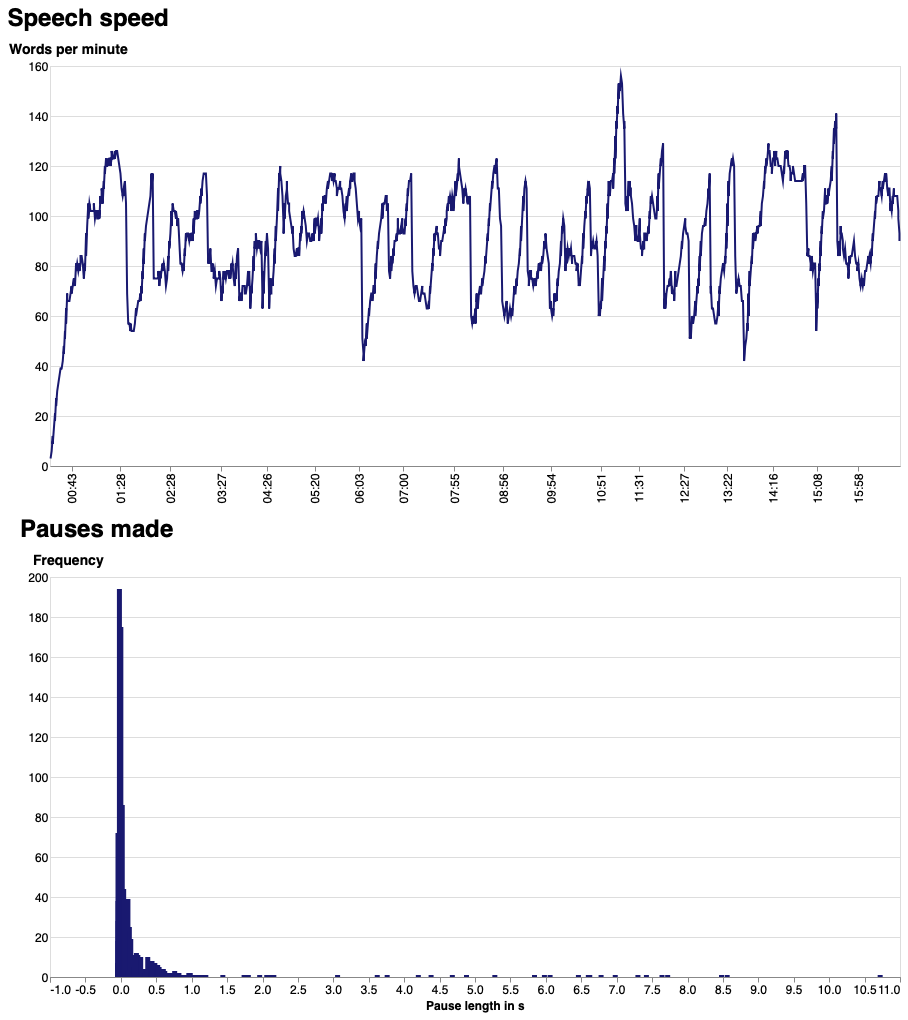

In [6]:
x1 = alt.Chart(speech_speed).mark_line().encode(
    alt.X('time:O', title = '', axis = alt.Axis(values = list(speech_speed['time'])[30::80])),
    alt.Y('speed:Q', title = 'Words per minute')
).properties(width = 850, height = 400, title = 'Speech speed')

x2 = alt.Chart(pauses).mark_bar().encode(
    alt.X('pauses:Q', title = 'Pause length in s'),
    alt.Y('count():Q', title = 'Frequency')
).properties(width = 850, height = 400, title = 'Pauses made')

alt.vconcat(x1, x2)

In [20]:
keys, occurence = [], []
for key, values in trump.powers.items():
    keys.append(key); occurence.append(sum(values))
    
keys2, occurence2 = [], []
for key, values in trump.senses.items():
    keys2.append(key); occurence2.append(sum(values))

In [14]:
data = {'power': list(trump.powers.keys()), 'occurence': [sum(value) for value in trump.powers.values()]}

In [22]:
powers = pd.DataFrame({'power': keys, 'occurence': occurence})
senses = pd.DataFrame({'sense': keys2, 'occurence': occurence2})

powers.loc[powers['power'] == 'Encouragement', 'power'] = 'Encouraging'
powers.loc[powers['power'] == 'Anger', 'power'] = 'Angry'
powers.loc[powers['power'] == 'Fear', 'power'] = 'Frightening'
powers.loc[powers['power'] == 'Forbidden', 'power'] = 'Inquisitive'
powers.loc[powers['power'] == 'Greed', 'power'] = 'Greedy'
powers.loc[powers['power'] == 'Lust', 'power'] = 'Passionate'
powers.loc[powers['power'] == 'Safety', 'power'] = 'Warming'

In [26]:
powers['power'] = powers['power'].astype(str)
powers['power'] = powers['power'].str.capitalize()
powers['rel_occurence'] = powers['occurence'] / sum(powers['occurence'])

senses['rel_occurence'] = senses['occurence'] / sum(senses['occurence'])

In [33]:
used_words = trump.count_word_frequencies()

In [34]:
words = []
occurence = []
pos = []
for key, values in used_words.items():
    pos.append([key] * len(values))
    words.append([term for term, occurence in values])
    occurence.append([occurence for term, occurence in values])

pos = [e for el in pos for e in el]
words = [e for el in words for e in el]
occurence = [e for el in occurence for e in el]

frequency = {'pos': pos, 'word': words, 'occurence': occurence}
word_frequencies = pd.DataFrame(frequency)

In [35]:
word_frequencies.loc[word_frequencies['pos'] == 'NOUN', 'word'] = word_frequencies.loc[word_frequencies['pos'] == 'NOUN', 'word'].str.capitalize()

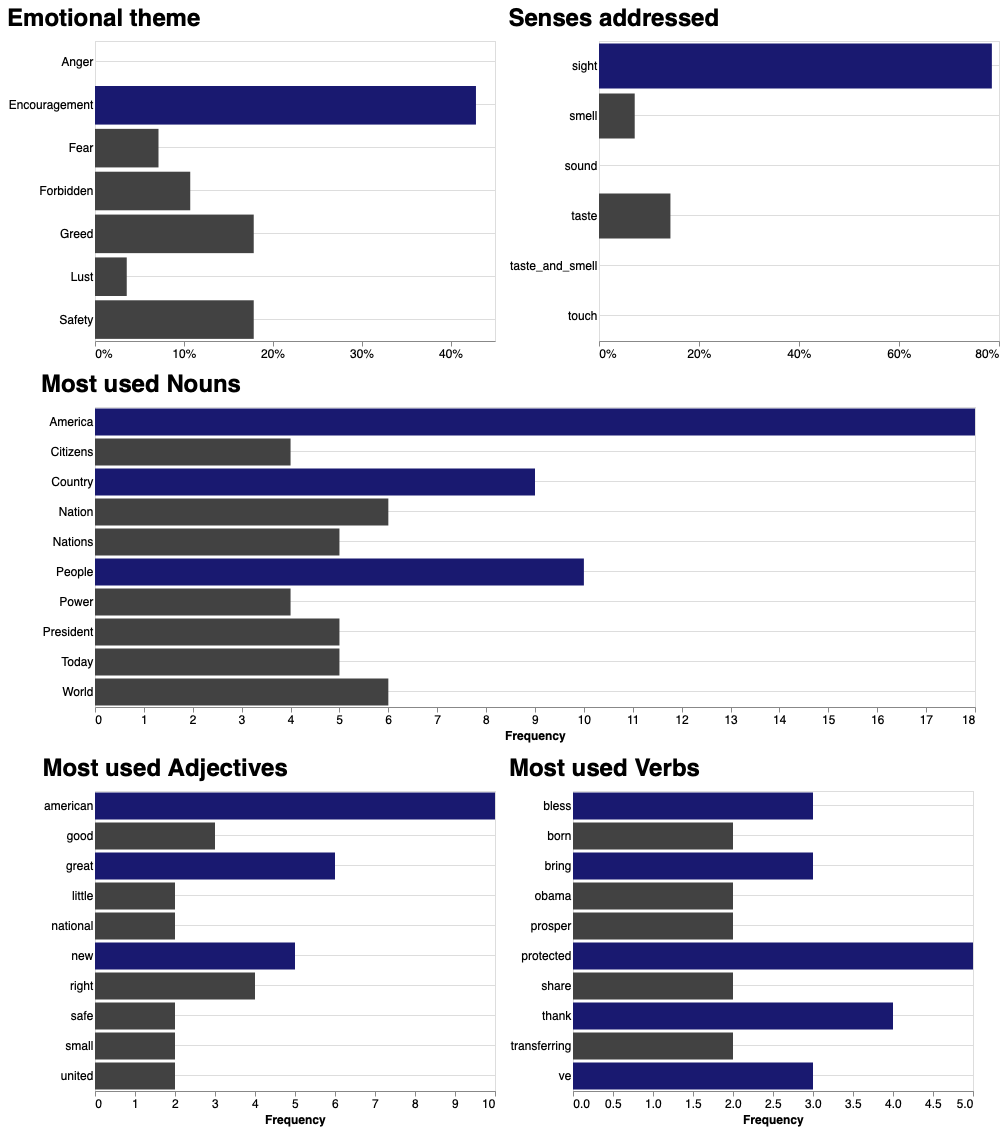

In [44]:
a1 = alt.Chart(powers).mark_bar().encode(
    alt.Y('power:N', title = ''),
    alt.X('rel_occurence:Q', title = '', axis = alt.Axis(format = '%', values = [0, 0.1, 0.2, 0.3, 0.4, 0.5])),
    color = alt.condition(
        alt.datum.occurence == max(powers['occurence']),
        alt.value('rgb(25,25,112'),
        alt.value('rgb(66,66,66)')
    )
).properties(width = 400, height = 300, title = 'Emotional theme')

a2 = alt.Chart(senses).mark_bar().encode(
    alt.Y('sense:N', title = ''),
    alt.X('rel_occurence:Q', title = '', axis = alt.Axis(format = '%', values = [0, 0.2, 0.4, 0.6, 0.8])),
    color = alt.condition(
        alt.datum.occurence == max(senses['occurence']),
        alt.value('rgb(25,25,112'),
        alt.value('rgb(66,66,66)')
    )
).properties(width = 400, height = 300, title = 'Senses addressed')

a3 = alt.Chart(word_frequencies.loc[word_frequencies['pos'] == 'NOUN']).mark_bar().encode(
    alt.X('occurence:Q', title = 'Frequency'),
    alt.Y('word:N', title = ''),
    color = alt.condition(
        alt.datum.occurence >= min(heapq.nlargest(3, list(word_frequencies.loc[word_frequencies['pos'] == 'NOUN', 'occurence']))),
        alt.value('rgb(25,25,112'),
        alt.value('rgb(66,66,66)')
    )
).properties(width = 880, height = 300, title = 'Most used Nouns')

a4 = alt.Chart(word_frequencies.loc[word_frequencies['pos'] == 'ADJ']).mark_bar().encode(
    alt.X('occurence:Q', title = 'Frequency'),
    alt.Y('word:N', title = ''),
    color = alt.condition(
        alt.datum.occurence >= min(heapq.nlargest(3, list(word_frequencies.loc[word_frequencies['pos'] == 'ADJ', 'occurence']))),
        alt.value('rgb(25,25,112'),
        alt.value('rgb(66,66,66)')
    )
).properties(width = 400, height = 300, title = 'Most used Adjectives')

a5 = alt.Chart(word_frequencies.loc[word_frequencies['pos'] == 'VERB']).mark_bar().encode(
    alt.X('occurence:Q', title = 'Frequency'),
    alt.Y('word:N', title = ''),
    color = alt.condition(
        alt.datum.occurence >= min(heapq.nlargest(3, list(word_frequencies.loc[word_frequencies['pos'] == 'VERB', 'occurence']))),
        alt.value('rgb(25,25,112'),
        alt.value('rgb(66,66,66)')
    )
).properties(width = 400, height = 300, title = 'Most used Verbs')

k = alt.hconcat(a1, a2)
j = alt.hconcat(a4, a5)
alt.vconcat(k, a3, j)

In [45]:
trump.lexical_diversity

13.451304323243175

In [47]:
trump.get_text_sentiment()

{'polarity': 0.16583743165375822, 'subjectivity': 0.42274665999155786}

In [49]:
trump.reading_ease

57.635742143833085

In [51]:
flesch = {'90-100': 'Very easy to follow.', '80-90': 'Conversational English',
          '70-80': 'Fairly easy to read.', '60-70': 'Plain English',
          '50-60': 'Fairly difficult to read', '30-50':'Difficult to read',
          '0-30': 'Very difficult to read'}

In [52]:
flesch

{'90-100': 'Very easy to follow.',
 '80-90': 'Conversational English',
 '70-80': 'Fairly easy to read.',
 '60-70': 'Plain English',
 '50-60': 'Fairly difficult to read',
 '30-50': 'Difficult to read',
 '0-30': 'Very difficult to read'}